# Recurrent Neural Networks

### RNN vs. FFNN

There are two main differences between FFNNs and RNNs. The Recurrent Neural Network uses:

1. **sequences** as inputs in the training phase, and
2. **memory** elements

Memory is defined as the output of hidden layer neurons, which will serve as additional input to the network during next training step.

### Representing Memory

RNN’s work well for sequences of data because they have a kind of **memory**. This memory is represented by something called the **hidden state**.

For example, in an character-level LSTM, each LSTM cell, in addition to accepting a character as input and generating an output character, also has some hidden state, and each cell will pass along its hidden state to the next cell.

This connection creates a kind of memory by which a series of cells can remember which characters they’ve just seen and use that information to inform the next prediction!

For example, if a cell has just generated the character `a` it likely will **not** generate another `a`, right after that!

### RNN vs. LSTM

**RNN** have a key flaw, as capturing relationships that span more than 8 or 10 steps back is practically impossible. This flaw stems from the **vanishing gradient** or **exploding gradient** problem in which the contribution of information decays geometrically over time.

**LSTM** is one option to overcome the Vanishing Gradient problem in RNNs.

### Simple RNN (aka Elman Network)

![](images/rnn-FFNN-RNN.svg)

In RNNs, our output at time $t$, depends not only on the current input and the weight, but also on previous inputs. In this case the output at time $t$ will be defined as:

$$\bar{y}_t = F(\bar{x}_t, \bar{x}_{t-1}, \ldots, \bar{x}_{t-t_0}, W)$$

![multi-layer RNN](images/rnn-ML-FFNN-RNN.svg)

When we train a RNN by Backpropagation Through Time, it means we first unroll the RNN in time by creating a copy of the network for each time step, viewing it as a multi-layer feedforward neural network, where the **number of layers** is equal to the **number of time steps**. Then we do backpropagation on the unrolled network, taking into account the **weight sharing**.

![](images/rnn.svg)

with the **input vector** $\bar{x}$, the **output vector** $\bar{y}$ and the **state vector** $\bar{s}$.

$W_x$ is the weight matrix connecting the inputs to the **state layer**, $W_y$ is the weight matrix connecting the state layer to the output layer and $W_s$ represents the weight matrix connecting the state from the previous timestep to the state in the current timestep.

In **FFNNs** the hidden layer depended only on the current inputs and weights, as well as on an nonlinear **activation function** $\Phi$ like $\text{tanh}$ or $\text{ReLU}$:

$$\bar{h} = \Phi(\bar{x} W)$$

In **RNNs** the state layer depended on the current inputs, their corresponding weights, the activation function and **also on the previous state**:

$$\bar{h} = \bar{s}_t = \Phi(\bar{x}_t W_x + \bar{s}_{t-1} W_s)$$

The output vector is calculated exactly the same as in FFNNs. It can be a linear combination of the inputs to each output node with the corresponding weight matrix $W_y$ or a **softmax function** $\sigma$ of the same linear combination:

$$\bar{y}_t = \bar{s}_t W_y \qquad \text{or} \qquad \bar{y}_t = \sigma(\bar{s}_t W_y)$$

### Example with torch.nn.RNN

`torch.nn.RNN` applies a multi-layer Elman RNN with $\tanh$ or $\text{ReLU}$ non-linearity to an input sequence.

For each element in the input sequence, each layer computes the following function:

$$s_t = \tanh(W_x \, x_t + b_x + W_s \, s_{t-1} + b_s)$$

In [1]:
import torch
import torch.nn as nn
torch.manual_seed(0)

# suppose we have a one hot encoding for each char in 'hello'
h = [1, 0, 0, 0]
e = [0, 1, 0, 0]
l = [0, 0, 1, 0]
o = [0, 0, 0, 1]

# and the sequence length for the word 'hello' is 5
seq_len = 5

# single layer RNN cell with input [4] -> output [2]
rnn = nn.RNN(input_size = 4, hidden_size = 2, num_layers = 1, batch_first = True)
rnn

RNN(4, 2, batch_first=True)

The functionality of `batch_first` is to **switch** the **timestep dimension** and the **batch dimension** of the **input** and **output**. 

The **hidden state** has no timestep dimension, hence `batch_first` has no affect on the hidden state.

In [2]:
inputs = torch.tensor([[h, e, l, l, o]], dtype = torch.float)              # [batch, seq_len, input_size] for batch_first=True

print(inputs.size())
print(inputs)

torch.Size([1, 5, 4])
tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]])


In [3]:
# 'hidden' is the state vector
hidden = torch.zeros(1, 1, 2)            # [num_layers, batch, hidden_size]

print(hidden.size())
print(hidden)

torch.Size([1, 1, 2])
tensor([[[0., 0.]]])


![](images/rnn-Example.svg)

In [4]:
out, hidden = rnn(inputs, hidden)

In [5]:
# 'out' contains all hidden states 's1' ... 's5' throughout the sequence
print(out.shape)
out

torch.Size([1, 5, 2])


tensor([[[-0.7497, -0.6135],
         [-0.5753, -0.0070],
         [-0.9077, -0.3205],
         [-0.9141, -0.2142],
         [-0.8996,  0.3307]]], grad_fn=<TransposeBackward1>)

In [6]:
# 'hidden' is the most recent hidden state (same as 'out[:,-1,:]')
print(hidden.shape)
hidden

torch.Size([1, 1, 2])


tensor([[[-0.8996,  0.3307]]], grad_fn=<StackBackward>)

#### Manual Calculation

In [7]:
# weight matrix
Ws = rnn.weight_hh_l0                            # [2,2]
Wx = rnn.weight_ih_l0                            # [2,4]

# bias vector
Bs = rnn.bias_hh_l0.view(-1, 1)                  # [2] -> [2,1]
Bx = rnn.bias_ih_l0.view(-1, 1)                  # [2] -> [2,1]

# input
X = inputs.squeeze(0)                            # [1,5,4] -> [5,4]
x1 = X[0].view(-1, 1)                            #     [4] -> [4,1]
x2 = X[1].view(-1, 1)
x3 = X[2].view(-1, 1)
x4 = X[3].view(-1, 1)
x5 = X[4].view(-1, 1)

# hidden states
hidden = torch.zeros(1, 1, 2)
s0 = hidden.squeeze(0).T                         # [1,1,2] -> [1,2] -> [2,1]
s1 = torch.tanh(Ws @ s0 + Bs + Wx @ x1 + Bx)     # [2,1]
s2 = torch.tanh(Ws @ s1 + Bs + Wx @ x2 + Bx)
s3 = torch.tanh(Ws @ s2 + Bs + Wx @ x3 + Bx)
s4 = torch.tanh(Ws @ s3 + Bs + Wx @ x4 + Bx)
s5 = torch.tanh(Ws @ s4 + Bs + Wx @ x5 + Bx)

print(f's5 = {s5.view(1,-1)}')

s5 = tensor([[-0.8996,  0.3307]], grad_fn=<ViewBackward>)


## Backpropagation Through Time (BPTT)

For the error calculations we use a **loss function**, where $E_t$ represents the **output error** at time $t$, $\bar{d}_t$ represents the **desired output** at time $t$ and $\bar{y}_t$ represents the calculated **output** at time $t$:

$$E_t = (\bar{d}_t - \bar{y}_t)^2$$




Suppose we calculate the output $\bar{y}_t = \bar{s}_t W_y$ and calculate the gradients at time $t = N$.

**Gradient Calculations to adjust Output Weight Matrix $W_y$**:

![](images/rnn-BPTT_Wy.svg)

$$\frac{\partial{E_N}}{\partial{W_y}} = \frac{\partial{E_N}}{\partial{\bar{y}_N}} \cdot \frac{\partial{\bar{y}_N}}{\partial{W_y}}$$

**Gradient Calculations to adjust State Weight Matrix $W_s$**:

to find the final gradient calculation, we **accumulate** the contributions from **all states**: $\bar{s}_t, \bar{s}_{t-1}, ..., \bar{s}_{t-N}$:

![](images/rnn-BPTT_Ws.svg)

$$\frac{\partial{E_N}}{\partial{W_s}} = \sum_{i=1}^{N} \frac{\partial{E_N}}{\partial{\bar{y}_N}} \cdot \frac{\partial{\bar{y}_N}}{\partial{\bar{s}_i}} \cdot \frac{\partial{\bar{s}_i}}{\partial{W_s}}$$

**Gradient Calculations to adjust Input Weight Matrix $W_x$**:

to find the final gradient calculation, we **accumulate** the contributions from **all inputs**: $\bar{x}_t, \bar{x}_{t-1}, ..., \bar{x}_{t-N}$:

![](images/rnn-BPTT_Wx.svg)

$$\frac{\partial{E_N}}{\partial{W_x}} = \sum_{i=1}^{N} \frac{\partial{E_N}}{\partial{\bar{y}_N}} \cdot \frac{\partial{\bar{y}_N}}{\partial{\bar{s}_i}} \cdot \frac{\partial{\bar{s}_i}}{\partial{W_x}}$$

### Example 1

Teach a RNN to produce *ihello* from *hihell* using `torch.nn.RNN`.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummaryX import summary

#### Data

In [15]:
# create an index to character mapping
idx2char= ['h', 'i', 'e', 'l', 'o']

# Teach hihell -> ihello
x_data = [[0, 1, 0, 2, 3, 3]]    # hihell

x_one_hot = [[[1, 0, 0, 0, 0],   # h 0
              [0, 1, 0, 0, 0],   # i 1
              [1, 0, 0, 0, 0],   # h 0
              [0, 0, 1, 0, 0],   # e 2
              [0, 0, 0, 1, 0],   # l 3
              [0, 0, 0, 1, 0]]]  # l 3

inputs = torch.tensor(x_one_hot, dtype=torch.float)
labels = torch.tensor([1, 0, 2, 3, 3, 4], dtype=torch.long) # ihello

In [16]:
inputs

tensor([[[1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0.]]])

In [17]:
labels

tensor([1, 0, 2, 3, 3, 4])

#### Model

We choose the following hyperparameters:

* **seq_len = 6**: `|hihell| == 6`, equivalent to time steps
* **input_size = 5**: one-hot size
* **batch_size = 1**: one sentence per batch
* **num_layers = 1**: one-layer rnn
* **num_classes = 5**: predicting 5 distinct characters
* **hidden_size = 4**: output from the RNN

In [18]:
class RNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(input_size = 5, hidden_size = 4, num_layers = 1, batch_first = True)
        self.linear = nn.Linear(in_features = 4, out_features = 5)

    def forward(self, x):
        hidden = torch.zeros(1, 1, 4)            # [num_layers, batch, hidden_size]
        x, _ = self.rnn(x, hidden)               # [1, 6, 4]
        x = x.view(-1, 4)                        # [6, 4]
        x = self.linear(x)                       # [6, 5]
        return x

rnn1 = RNN1()

summary(rnn1, inputs);

         Kernel Shape Output Shape  Params  Mult-Adds
Layer                                                
0_rnn               -    [1, 6, 4]      44         36
1_linear       [4, 5]       [6, 5]      25         20
-----------------------------------------------------
                      Totals
Total params              69
Trainable params          69
Non-trainable params       0
Mult-Adds                 56


#### Train the Model

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn1.parameters(), lr = 0.1)

num_epochs = 15
losses = []
for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()
    outputs = rnn1(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    _, idx = outputs.max(dim = 1)
    idx = idx.data.numpy()
    result_str = [idx2char[c] for c in idx]
    print(f"epoch: {epoch:2}, loss: {loss.item():1.3f}, predicted string: {''.join(result_str)}")

epoch:  1, loss: 1.611, predicted string: oooooo
epoch:  2, loss: 1.436, predicted string: ooolll
epoch:  3, loss: 1.281, predicted string: eeelll
epoch:  4, loss: 1.133, predicted string: eeelll
epoch:  5, loss: 0.986, predicted string: ehelll
epoch:  6, loss: 0.838, predicted string: ehelll
epoch:  7, loss: 0.709, predicted string: ehelll
epoch:  8, loss: 0.594, predicted string: ehello
epoch:  9, loss: 0.489, predicted string: ehello
epoch: 10, loss: 0.407, predicted string: ehello
epoch: 11, loss: 0.352, predicted string: ihello
epoch: 12, loss: 0.310, predicted string: ihello
epoch: 13, loss: 0.275, predicted string: ihello
epoch: 14, loss: 0.249, predicted string: ihello
epoch: 15, loss: 0.228, predicted string: ihello


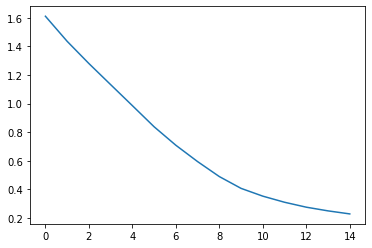

In [21]:
import matplotlib.pyplot as plt
plt.plot(losses);

### Example 2

As an example we have a **sequence** of single numbers (`input_size`), hence having one feature:
```
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
```

We divide it into **4 batches** (`batch_size`) of **sequence length = 5** (`seq_len`):

```
[[1, 2, 3, 4, 5],
 [6, 7, 8, 9, 10],
 [11, 12, 13, 14, 15],
 [16, 17, 18, 19, 20]]
```

Our aim is to looking at 5 (`seq_len`) previous value to **predict the next value** (`hiden_size`).

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummaryX import summary

In [40]:
#data = torch.Tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])
data = torch.Tensor([1, 2, 3, 4, 5, 6])

#inputs = data[:-1].view(4, 5, 1)                       # all but the last piece of data
#labels = data[1:].view(4, 5, 1)                        # all but the first

inputs = data[:-1].view(1, 5, 1)                        # all but the last piece of data
labels = data[1:].view(1, 5, 1)                         # all but the first

In [49]:
class RNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(input_size = 1, hidden_size = 4, num_layers = 1, batch_first = True)
        self.fc = nn.Linear(in_features = 4, out_features = 1)

    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = x.reshape(-1, 4)
        x = self.fc(x)
        return x, hidden

rnn2 = RNN2()

summary(rnn2, inputs, torch.zeros(1, 1, 4));

      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_rnn            -    [1, 5, 4]      28         20
1_fc        [4, 1]       [5, 1]       5          4
--------------------------------------------------
                      Totals
Total params              33
Trainable params          33
Non-trainable params       0
Mult-Adds                 24


#### Train the Model

In [48]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

num_epochs = 10
losses = []

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0
    hidden = torch.zeros(1,1,4)
    for batch_input in inputs:
        batch_input = batch_input.unsqueeze(0)
        
        predictions, hidden = rnn2(batch_input, hidden)
    
        loss = criterion(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss = epoch_loss + loss.data
    
    # make a new variable for hidden and detach the hidden state from its history
    # this way, we don't backpropagate through the entire history
    #hidden = None
    
    epoch_loss = epoch_loss / inputs.size(0)
    losses.append(epoch_loss)
#    _, idx = outputs.max(dim = 1)
#    idx = idx.data.numpy()
#    result_str = [idx2char[c] for c in idx]
    print(f"epoch: {epoch:2}, loss: {epoch_loss.item():1.3f}, predicted number: {predictions.data[0]}")

epoch:  1, loss: 21.436, predicted number: tensor([0.0316])
epoch:  2, loss: 21.436, predicted number: tensor([0.0316])
epoch:  3, loss: 21.436, predicted number: tensor([0.0316])
epoch:  4, loss: 21.436, predicted number: tensor([0.0316])
epoch:  5, loss: 21.436, predicted number: tensor([0.0316])
epoch:  6, loss: 21.436, predicted number: tensor([0.0316])
epoch:  7, loss: 21.436, predicted number: tensor([0.0316])
epoch:  8, loss: 21.436, predicted number: tensor([0.0316])
epoch:  9, loss: 21.436, predicted number: tensor([0.0316])
epoch: 10, loss: 21.436, predicted number: tensor([0.0316])


### Gradient Clipping

TODO: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48